In [15]:
## Scikit learn libraries
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

## For NLP
from bs4 import BeautifulSoup, Tag    ## Cleaning HTML tags from text
import nltk, string
from nltk.corpus import stopwords 
import re

## Common Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data I/O
import json     ## To convert json raw data to df
import pickle   ## saving the model to disk

import xgboost as xgb
from scipy.stats import uniform, randint

#from keras.preprocessing import text, sequence
#from keras import layers, models, optimizers

## Problem texts can be long and may not load on Jupyter
pd.set_option('display.max_colwidth', -1)    

## Extract subject wise training data

In [2]:
# Load the dataset and show sample question
with open('../data/qs_topicwise.json') as json_data:
    all_questions = json.load(json_data)

subject_model = ['PHY']

## Create empty df 
data_df = pd.DataFrame(columns=['curriculum', 'subject', 'question_text', 'chapter'])

## Removing these words improves Phy clf accuracy by 2% but improves Math classifier accuracy
words_to_remove = ["rightarrow", "hence", "frac", "text", "sqrt", "times", 
                   "value", "amp", "statement", "will", "equal", "number", 
                   "tan", "now", "can", "two", "get", "true", "lambda", "a", "an", "the"]
stop_words = stopwords.words('english')         ## Downloaded from NLTK
'''
Stopwords reduce acc & f1 score for Physics. 67% -> 63%, 74% -> 72%

'''

## Remove dummy and empty chapters
chapters_to_remove = ['Selection Test', 'Repository', 'Bridge Intervention Curriculum', 
                      'M1.1 Scaffold test', 'Tally Marks', 'Dummy']
chapters_with_no_data = ['Static Electricity', 'Experimental Skills', 'Nuclear Chemistry', 
                         'Principle of Mathematical Induction', 'Environmental Chemistry']

## Regex pattern for alpha numeric - Improves accuracy & f1-score for Phy by 2%
pattern = re.compile('[\W_]+')

i = 0
for question in all_questions:
    try: 
        question_text = question['question_text'].lower()
        ## Remove HTML tags from text using Beautiful Soup
        '''
        For MTH, it improves accuracy from 40% to 60% in MTH, 
        For PHY, it reduces accuracy from 60% to 20%. 
        For CHM, it increases accuracy from 50% to 52% 
        '''
        question_text = BeautifulSoup(question_text, "html.parser").get_text() 
        ## Remove numbers
        '''
        For PHY, improved accuracy & F1 score by 0.5%
        '''
        question_text = ''.join(c for c in question_text if not c.isdigit())
        ## Regex pattern for alpha numeric text
        question_text = pattern.sub(" ", question_text)
        ## Remove stop words
        question_text = " ".join([word for word in question_text.split() if word not in words_to_remove])
        #question_text = " ".join([word for word in question_text.split() if word not in stop_words])
        ## Remove extra whitespaces
        question_text = " ".join(question_text.split()) 
        ## Extracting elements for cleaner code
        grade = question['grade']
        curriculum = question['curriculum']
        chapter = question['chapter']
        subject = question['subject']
        ## Filtering each question from JSON to add relevant Qs to dataframe 
        if(    "JEE" in curriculum and grade in ["11", "12"] and
               chapter not in chapters_to_remove and
               chapter not in chapters_with_no_data and
               "dummy" not in question_text and subject in subject_model):
                data_df.loc[i] = [curriculum, subject, question_text, chapter]
                i += 1
    except:
            pass

trainDF = pd.DataFrame(columns=['text', 'label'])
trainDF['text'] = data_df['question_text']
trainDF['label'] = data_df['chapter']
trainDF.head(3)

,text,label
0,which of following changes increase stopping potential,Modern Physics
1,keeping frequency as well intensity of light source constant if we gradually increase potential of anode giving it positive potential w r t cathode,Modern Physics
2,photons photon photon are travelling in vacuum consider following cases case when photons are travelling in same direction case when photons are travelling in opposite directions speed of photon w r t photon,Modern Physics


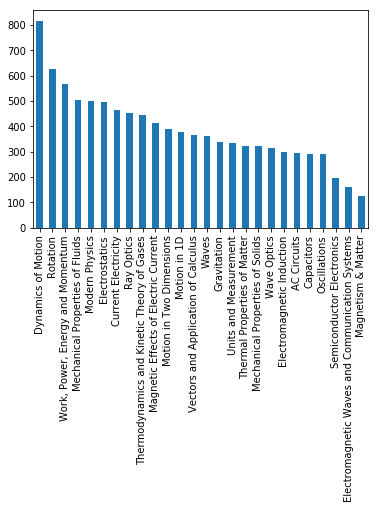

In [3]:
trainDF.label.value_counts().plot(kind="bar")

## Train test split

In [4]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(trainDF['text'], trainDF['label'], test_size=0.2)
print(len(train_x), len(valid_x) )

8061 2016


## Create pipeline for vectorizer & classifier

Label encoding is not needed. All sklearn classifiers are capable of mutli-class classification. Source :  https://stackoverflow.com/questions/51525043/encoding-labels-for-multi-class-problems-in-sckit-learn

In [5]:
## Custom Tokenizer for Vectorizer (no default by sklearn)
'''
Improves accuracy & f1 score for PHY by 2%
'''
stemmer = nltk.stem.porter.PorterStemmer()    ## May need to download this with "nltk.download('punkt')"
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.translate(remove_punctuation_map)))

## Initializing vectorizer
vec = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3),
                      lowercase=True, tokenizer=normalize, max_features=10000, 
                      use_idf = True, min_df = 5, max_df = 0.8, stop_words = None)
## Can't add stop words here as the text is normalized and it won't match the stop words list. Should remove earlier.
## https://stackoverflow.com/questions/57340142/user-warning-your-stop-words-may-be-inconsistent-with-your-preprocessing

## Initializaing classifier
#clf = naive_bayes.MultinomialNB()
#clf = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg')
clf = xgb.XGBClassifier(objective="multi:softprob", random_state=42)

## Setting up pipeline
pipe = make_pipeline(vec, clf)
pipe.fit(train_x, train_y)

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=10000, min_df=5,
        ngram_range=(2, 3), norm='l2', preprocessor=None, smoot...
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1))])

## Prediction & Evaluation metrics

In [6]:
pred_y = pipe.predict(valid_x)
report = metrics.classification_report(valid_y, pred_y)
print(report)
print("accuracy: {:0.3f}".format(metrics.accuracy_score(valid_y, pred_y)))
print("F1-score (weighted): {:0.3f}".format(metrics.f1_score(valid_y, pred_y, average = 'weighted')))
## Support is the number of occurrences of each class in valid_y

                                                 precision    recall  f1-score   support

                                    AC Circuits       0.78      0.49      0.60        57
                                     Capacitors       0.71      0.74      0.73        54
                            Current Electricity       0.63      0.58      0.61        86
                             Dynamics of Motion       0.32      0.84      0.46       166
                      Electromagnetic Induction       0.72      0.41      0.52        68
Electromagnetic Waves and Communication Systems       0.85      0.37      0.51        30
                                 Electrostatics       0.80      0.80      0.80        92
                                    Gravitation       0.81      0.79      0.80        61
           Magnetic Effects of Electric Current       0.61      0.79      0.69        85
                             Magnetism & Matter       0.86      0.22      0.35        27
                Mech

This is a higher accuracy than the baseline Naive Bayes model made earlier !
It can be attributed to the Logistic Regression model, along with custom tokenizer better hyper parameters

### Hyper-parameter optimization (don't run locally)

In [ ]:
'''
## This will consume 100% CPU, run on Kaggle / server
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)

vec.fit(trainDF['text'])
xtrain_tfidf_ngram =  vec.transform(train_x)

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = model_selection.RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200,
                            cv=3, verbose=1, n_jobs=1, return_train_score=True)

#search.fit(train_x[:,np.newaxis], train_y)
search.fit(xtrain_tfidf_ngram, train_y)

report_best_scores(search.cv_results_, 1)
'''

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


#### Chapters that were never predicted

In [7]:
set(valid_y) - set(pred_y)

set()

### Check + and - weights of the model, and which feature contribute to prediction
Manually

In [8]:
'''
for i, tag in enumerate(clf.classes_):
    coefficients = clf.coef_[i]
    weights = list(zip(vec.get_feature_names(),coefficients))
    print('Tag:',tag)
    print('Most Positive Coefficients:')
    print(sorted(weights,key=lambda x: -x[1])[:10])
    print('Most Negative Coefficients:')
    print(sorted(weights,key=lambda x: x[1])[:10])
    print("--------------------------------------")
'''

'\nfor i, tag in enumerate(clf.classes_):\n    coefficients = clf.coef_[i]\n    weights = list(zip(vec.get_feature_names(),coefficients))\n    print(\'Tag:\',tag)\n    print(\'Most Positive Coefficients:\')\n    print(sorted(weights,key=lambda x: -x[1])[:10])\n    print(\'Most Negative Coefficients:\')\n    print(sorted(weights,key=lambda x: x[1])[:10])\n    print("--------------------------------------")\n'

#### +ve and -ve Weights using eli5

In [9]:
import eli5
eli5.show_weights(clf, vec=vec, top=50)

Weight,Feature
0.0107,s modulu
0.0088,g m
0.0087,block of mass
0.0076,moment of inertia
0.0049,of densiti
0.0044,doubl slit
0.0044,ideal ga
0.0043,and vec
0.0042,circ c
0.0041,simpl harmon


## Misclassified Examples

In [10]:
valid = pd.concat([valid_x, valid_y], axis=1)
valid['pred'] = pred_y
valid.head(10)

,text,label,pred
3176,magnetic flux is vector quantity,Electromagnetic Induction,Electromagnetic Induction
6924,ring of radius r is first rotated with angular velocity omega and then carefully placed on rough horizontal surface coefficient of friction between surface and ring is mu time after which its angular speed is reduced to half is,Rotation,Rotation
1940,battery has open circuit potential difference of v between its terminals and internal resistance r when load resistance r of omega is connected across battery total power dissipated in circuit is w what should be load resistance r so that maximum power be dissipated in r calculate this power what is total power supplied by battery when such load is connected,Current Electricity,AC Circuits
1652,current is said to be in direction of motion of,Current Electricity,Dynamics of Motion
7564,water from tap emerges vertically downwards with initial speed of ms cross sectional area of tap is m assume that pressure is constant throughout stream of water and that flow is streamlined cross sectional area of stream m below tap would be take g ms,Mechanical Properties of Fluids,Mechanical Properties of Fluids
1943,in circuit shown currents in through v and v batteries are respectively,Current Electricity,Current Electricity
7006,pulley of radius m is rotated about its axis by force f left t t right newton where t is measured in second applied tangentially force is then withdrawn if moment of inertia of pulley about its axis of rotation is kg m of rotations made by pulley before its direction of motion is reversed is very nearly to,Rotation,Rotation
6779,distance from axis of point mass whose mass is to mass of whole body and whose moment of inertia is to moment of inertia of whole body about given axis is called,Rotation,Rotation
170,cu is wavelength of k alpha x ray line of cu and mo is wavelength of k alpha x ray line of mo then cu mo is,Modern Physics,Modern Physics
3613,coil of galvanometer is m it consists of turns of wire and is in magnetic field of t restoring constant of suspension wire is nm degree assuming magnetic field to be radial what is smallest current that be detected if minimum observed deflection is,Magnetic Effects of Electric Current,Magnetic Effects of Electric Current


In [11]:
misclassified_examples = valid[valid.label != valid.pred]
misclassified_examples.head()

,text,label,pred
1940,battery has open circuit potential difference of v between its terminals and internal resistance r when load resistance r of omega is connected across battery total power dissipated in circuit is w what should be load resistance r so that maximum power be dissipated in r calculate this power what is total power supplied by battery when such load is connected,Current Electricity,AC Circuits
1652,current is said to be in direction of motion of,Current Electricity,Dynamics of Motion
7195,fluid is substance which offers no resistance to change of,Mechanical Properties of Fluids,Dynamics of Motion
2881,ac voltmeter is used to measure this alternating voltage v v sin 𝜔t what be rating on that voltmeter,AC Circuits,Current Electricity
7,phenomenon of polarization of light indicates that,Modern Physics,Dynamics of Motion


##### Checking 2nd row

In [12]:
eli5.show_prediction(clf, misclassified_examples['text'].values[1], vec=vec)